In [220]:
pip install faiss-cpu

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [221]:
#Importing the necessary libraries
import json
import numpy as np
import pandas as pd
import faiss
import time

# Load cleaned metadata
spotify = pd.read_parquet("data/spotify_clean.parquet")
print("Metadata shape:", spotify.shape)

# Load embeddings
embeddings = np.load("data/spotify_vectors_14d.npy").astype("float32")
print("Embedding matrix:", embeddings.shape)

# Load query workload
with open("data/query_workload.json") as f:
    workload = json.load(f)
print("Loaded queries:", len(workload))


Metadata shape: (169776, 19)
Embedding matrix: (169776, 14)
Loaded queries: 150


### Ground-Truth Index for Exact Similarity Search

We construct a full exact FAISS index using `IndexFlatL2`, which computes true L2 distances across the entire embedding set.  
Since this index exhaustively compares every vector, it provides perfect-recall nearest neighbors, making it the correct reference for evaluating our baseline and hybrid retrieval methods.


In [222]:
# Exact L2 index (FULL recall)
d = embeddings.shape[1]
gt_index = faiss.IndexFlatL2(d)
gt_index.add(embeddings)

print("Ground-truth index ready with", gt_index.ntotal, "vectors")


Ground-truth index ready with 169776 vectors


In [223]:
# Helper function to measure the execution time (in milliseconds) of any search method. 
# Utility: measure execution time (ms) for a given function call
def timed(fn, *args, **kwargs):
    start = time.time()
    result = fn(*args, **kwargs)
    latency = (time.time() - start) * 1000
    return result, latency


In [224]:
# Apply metadata filters (year, explicit, tempo, duration, etc.)
# A utility function that filters the DataFrame according to the query’s structured constraints.

def apply_filters(df, filt):
    df2 = df.copy()

    for key, val in filt.items():
        if key == "year":
            lo, hi = val
            df2 = df2[(df2["year"] >= lo) & (df2["year"] <= hi)]
        elif key == "explicit":
            df2 = df2[df2["explicit"] == val]
        elif key == "key":
            df2 = df2[df2["key"] == val]
        elif key == "tempo":
            lo, hi = val
            df2 = df2[(df2["tempo"] >= lo) & (df2["tempo"] <= hi)]
        elif key == "duration_ms":
            lo, hi = val
            df2 = df2[(df2["duration_ms"] >= lo) & (df2["duration_ms"] <= hi)]
        elif key == "danceability":
            lo, hi = val
            df2 = df2[(df2["danceability"] >= lo) & (df2["danceability"] <= hi)]
        elif key == "energy":
            lo, hi = val
            df2 = df2[(df2["energy"] >= lo) & (df2["energy"] <= hi)]

        elif key == "popularity":   
            lo, hi = val
            df2 = df2[(df2["popularity"] >= lo) & (df2["popularity"] <= hi)]

    return df2.sort_index()


### Ground-truth computation for filtered queries
To evaluate recall correctly, we must compute true neighbors within the filtered result set.  This function first applies structured metadata filters (year, explicit, tempo, etc.) and then performsa full exact L2 search over the remaining items. The returned indices represent the true top-K neighbors and are used as the standard reference when evaluating pre-filter and post-filter baselines.


In [225]:
def get_ground_truth(qid, filt, K):
    df_f = apply_filters(spotify, filt)

    if len(df_f) == 0:
        return np.array([])

    idxs = df_f.index.values
    vecs = embeddings[idxs]

    qvec = embeddings[qid].reshape(1, -1)
    dists = np.linalg.norm(vecs - qvec, axis=1)

    # sorted filtered candidates → return global indices
    topk_local = np.argsort(dists)[:K]
    return idxs[topk_local]


### Pre-filter baseline (Filter first, then exact search)
This method implements the classical pre-filtering strategy:
1. Apply all metadata constraints (year range, explicit flag, tempo range, etc.) to prune the dataset.
2. Perform an exact L2 nearest-neighbor search only on the filtered candidates.
3. Return the global indices of the top-K closest items.

Because the ANN search is avoided and filters are applied before ranking, this baseline should 
match ground truth recall exactly whenever the filter set is large enough to contain K neighbors.


In [226]:
def pre_filter_search(qid, filt, K):
    df_f = apply_filters(spotify, filt)
    if len(df_f) == 0:
        return np.array([])

    idxs = df_f.index.values
    vecs = embeddings[idxs]

    qvec = embeddings[qid].reshape(1, -1)
    d = np.linalg.norm(vecs - qvec, axis=1)
    topk_local = np.argsort(d)[:K]

    return idxs[topk_local]

### Post-filter baseline (Search first, then filter, then rerank)
This method implements the  post-filtering pipeline:
1. Perform a nearest-neighbor search using the full index to retrieve a larger candidate pool 
   (controlled by `pool_size`, analogous to `efSearch` or `nprobe` in ANN systems).
2. Apply all structured metadata constraints to filter out invalid candidates.
3. Recompute exact L2 distances on the surviving items to obtain an accurate ranking.
4. Return the global indices of the top-K closest results.

Unlike pre-filtering, post-filtering may lose recall if the retrieved pool does not contain enough valid candidates, but it often performs faster when filters are broad.


In [227]:
def post_filter_search(qid, filt, K, pool_size=500):
    qvec = embeddings[qid].reshape(1, -1)
    D, I = gt_index.search(qvec, pool_size)   # ANN would go here

    # Candidate dataframe
    df_c = spotify.iloc[I[0]]
    df_c = apply_filters(df_c, filt)

    if len(df_c) == 0:
        return np.array([])

    # Compute distances again for filtered candidates
    idxs = df_c.index.values
    d = np.linalg.norm(embeddings[idxs] - qvec, axis=1)
    topk_local = np.argsort(d)[:K]

    return idxs[topk_local]


In [228]:
# Computes the fraction of ground-truth neighbors that appear in the predicted top-K results
def recall_at_k(gt, pred):
    gt = np.array(gt, dtype=int)
    pred = np.array(pred, dtype=int)

    gt = gt[gt >= 0]
    pred = pred[pred >= 0]

    if len(gt) == 0:
        return 1.0 if len(pred) == 0 else 0.0

    overlap = len(set(gt) & set(pred))
    return overlap / len(gt)



### Running Baseline Experiments: Latency and Recall@K

For each query in the workload, we evaluate both baseline strategies—Pre-filter and Post-filter—under the same conditions.  

For every query:

1. **Ground truth retrieval**  
   We compute the exact top-K nearest neighbors *after applying metadata filters*, using brute-force L2 search.

2. **Pre-filter baseline**  
   - Apply metadata filters directly to the dataframe.  
   - Perform exact nearest-neighbor search on the filtered subset.  
   - Measure latency and compute Recall@K against the ground truth.

3. **Post-filter baseline**  
   - Retrieve a large candidate pool using exact L2 search (ANN placeholder).  
   - Apply metadata filters to the candidate set.  
   - Recompute distances and return the top-K.  
   - Measure latency and compute Recall@K.

We store latency and recall for both methods across all queries to compare correctness (Recall@K) and efficiency (ms latency) across different filter selectivities.


In [229]:
results = []
K = 10

for q in workload:
    qid = q["query_id"]
    filt = q["filters"]

    # Ground truth
    gt = get_ground_truth(qid, filt, K)

    # Pre
    pre, pre_ms = timed(pre_filter_search, qid, filt, K)
    pre_recall = recall_at_k(gt, pre)

    # Post
    post, post_ms = timed(post_filter_search, qid, filt, K)
    post_recall = recall_at_k(gt, post)

    results.append({
        "qid": qid,
        "filters": filt,
        "pre_recall": pre_recall,
        "post_recall": post_recall,
        "pre_ms": pre_ms,
        "post_ms": post_ms
    })

results_df = pd.DataFrame(results)
results_df.head()


,qid,filters,pre_recall,post_recall,pre_ms,post_ms
0,128060,"{'year': [2006, 2007], 'explicit': 0, 'key': 6}",1.0,0.0,7.753134,1.653910
1,77384,"{'year': [1964, 1966], 'explicit': 0}",1.0,1.0,7.766008,1.569033
2,105260,"{'year': [2004, 2005], 'explicit': 1}",1.0,0.3,7.054090,1.667023
3,42918,"{'year': [1981, 1983], 'explicit': 0, 'key': 8}",1.0,0.0,7.169008,1.527071
4,24661,"{'year': [2007, 2008], 'explicit': 0}",1.0,0.0,6.476164,1.487255


### Baseline Evaluation Plots

- **Latency comparison:** shows how pre-filter vs. post-filter latency changes across the query workload.  
- **Recall@K plot:** compares retrieval accuracy of both baselines against ground truth.  
- **Latency vs. selectivity:** illustrates how filtering selectivity affects each method’s performance.  
- **Selectivity distribution:** confirms that the workload spans narrow, broad, and mixed filters.  


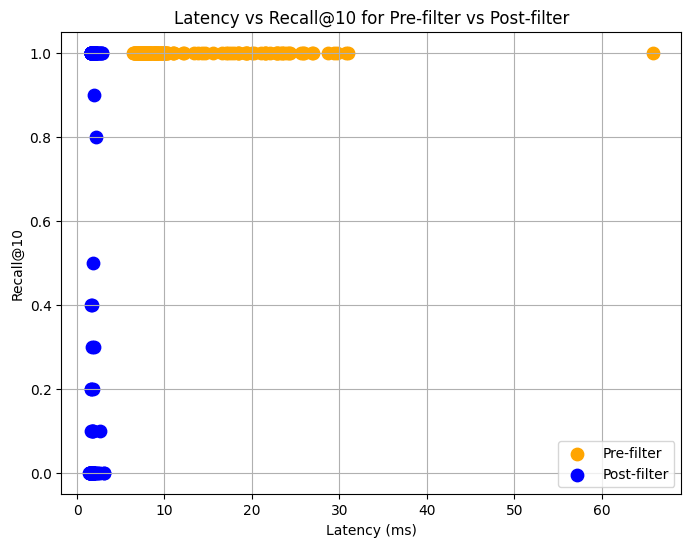

In [230]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(results_df["pre_ms"], results_df["pre_recall"], 
            color="orange", label="Pre-filter", s=80)
plt.scatter(results_df["post_ms"], results_df["post_recall"], 
            color="blue", label="Post-filter", s=80)

plt.xlabel("Latency (ms)")
plt.ylabel("Recall@10")
plt.title("Latency vs Recall@10 for Pre-filter vs Post-filter")
plt.legend()
plt.grid(True)
plt.show()


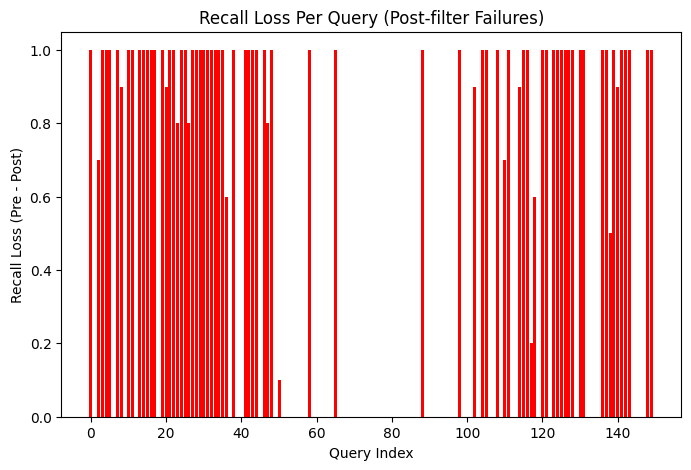

In [231]:
plt.figure(figsize=(8,5))

recall_drop = results_df["pre_recall"] - results_df["post_recall"]
plt.bar(range(len(recall_drop)), recall_drop, color="red")

plt.xlabel("Query Index")
plt.ylabel("Recall Loss (Pre - Post)")
plt.title("Recall Loss Per Query (Post-filter Failures)")
plt.show()


In [232]:
import ast

def parse_filter(f):
    if isinstance(f, dict):
        return f
    if isinstance(f, str):
        return ast.literal_eval(f)
    raise ValueError("Unknown filter format: " + str(f))

selectivity = []

for idx, row in results_df.iterrows():
    filt = parse_filter(row["filters"])
    df = spotify.copy()   # ← FIXED LINE

    # Apply filters safely
    if "year" in filt:
        lo, hi = filt["year"]
        df = df[(df["year"] >= lo) & (df["year"] <= hi)]
    if "explicit" in filt:
        df = df[df["explicit"] == filt["explicit"]]
    if "key" in filt:
        df = df[df["key"] == filt["key"]]
    if "tempo" in filt:
        lo, hi = filt["tempo"]
        df = df[(df["tempo"] >= lo) & (df["tempo"] <= hi)]

    selectivity.append(len(df))

results_df["selectivity"] = selectivity


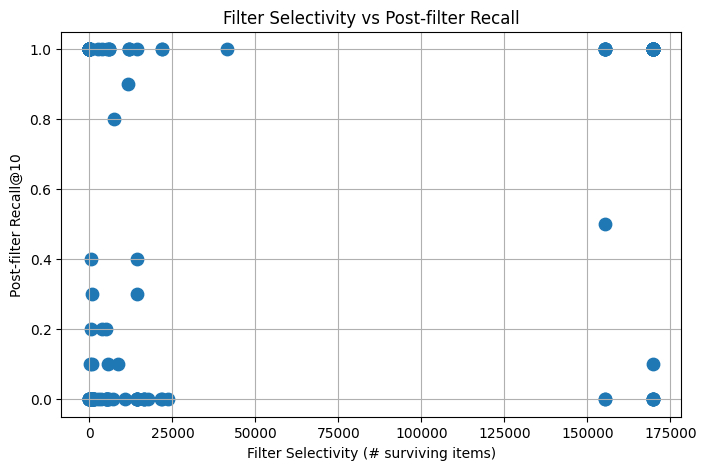

In [233]:
plt.figure(figsize=(8,5))
plt.scatter(results_df["selectivity"], results_df["post_recall"], s=80)
plt.xlabel("Filter Selectivity (# surviving items)")
plt.ylabel("Post-filter Recall@10")
plt.title("Filter Selectivity vs Post-filter Recall")
plt.grid(True)
plt.show()


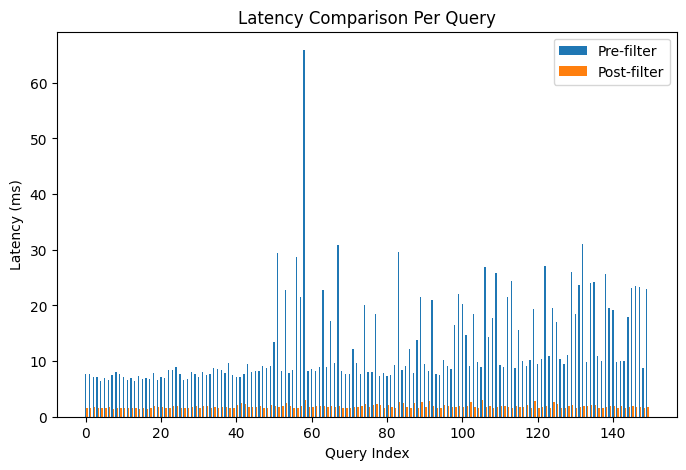

In [234]:
plt.figure(figsize=(8,5))
width = 0.35
x = range(len(results_df))

plt.bar(x, results_df["pre_ms"], width=width, label="Pre-filter")
plt.bar([i + width for i in x], results_df["post_ms"], width=width, label="Post-filter")

plt.xlabel("Query Index")
plt.ylabel("Latency (ms)")
plt.title("Latency Comparison Per Query")
plt.legend()
plt.show()


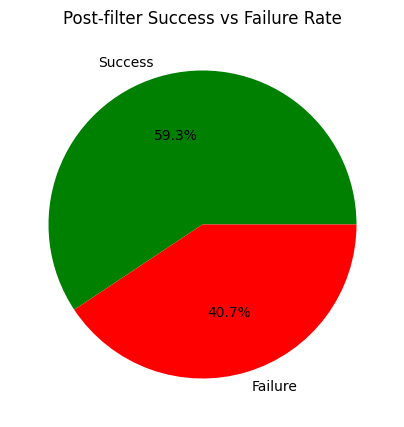

In [235]:
failures = sum(results_df["post_recall"] == 0)
successes = len(results_df) - failures

plt.figure(figsize=(5,5))
plt.pie([successes, failures], labels=["Success", "Failure"],
        autopct="%1.1f%%", colors=["green", "red"])
plt.title("Post-filter Success vs Failure Rate")
plt.show()


### Robustness Check

Checking the evaluation metrics for different values of K to make sure that our observations hold.

In [236]:
K_values = [5, 10, 20, 50]
multiK_results = []

for K in K_values:
    print(f"\n=== Running baselines for K = {K} ===")
    
    for q in workload:
        qid = q["query_id"]
        filt = q["filters"]

        # Ground truth
        gt = get_ground_truth(qid, filt, K)

        # Pre-filter
        pre_idx, pre_ms = timed(pre_filter_search, qid, filt, K)
        pre_recall = recall_at_k(gt, pre_idx)

        # Post-filter
        post_idx, post_ms = timed(post_filter_search, qid, filt, K)
        post_recall = recall_at_k(gt, post_idx)

        multiK_results.append({
            "qid": qid,
            "filters": str(filt),
            "K": K,
            "pre_recall": pre_recall,
            "post_recall": post_recall,
            "pre_ms": pre_ms,
            "post_ms": post_ms
        })

# Convert to DataFrame
multiK_df = pd.DataFrame(multiK_results)
multiK_df.head()



=== Running baselines for K = 5 ===

=== Running baselines for K = 10 ===

=== Running baselines for K = 20 ===

=== Running baselines for K = 50 ===


,qid,filters,K,pre_recall,post_recall,pre_ms,post_ms
0,128060,"{'year': [2006, 2007], 'explicit': 0, 'key': 6}",5,1.0,0.0,8.475780,1.675129
1,77384,"{'year': [1964, 1966], 'explicit': 0}",5,1.0,1.0,9.001017,1.654863
2,105260,"{'year': [2004, 2005], 'explicit': 1}",5,1.0,0.6,8.542299,2.417803
3,42918,"{'year': [1981, 1983], 'explicit': 0, 'key': 8}",5,1.0,0.0,10.195971,1.537085
4,24661,"{'year': [2007, 2008], 'explicit': 0}",5,1.0,0.0,9.320021,1.590967


In [237]:
multiK_df.groupby("K")[["pre_recall", "post_recall", "pre_ms", "post_ms"]].mean()


,pre_recall,post_recall,pre_ms,post_ms
K,,,,
5,1.0,0.546667,12.384286,1.801907
10,1.0,0.524667,11.483698,1.712596
20,1.0,0.498333,11.643877,1.713320
50,1.0,0.456000,12.401206,1.841389


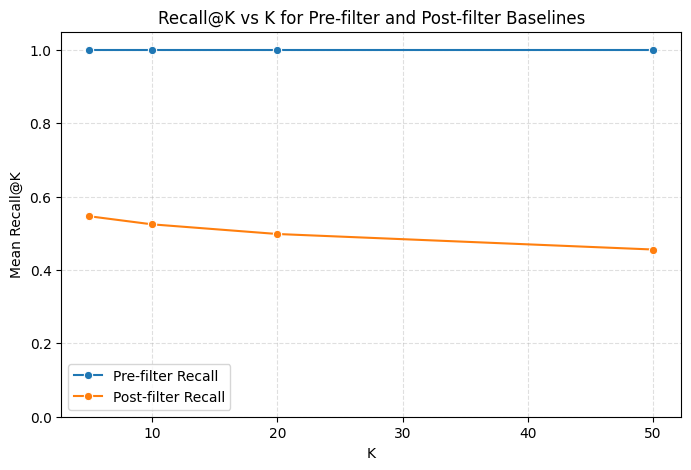

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

# Compute mean recall for each K
recall_summary = multiK_df.groupby("K")[["pre_recall", "post_recall"]].mean().reset_index()

sns.lineplot(data=recall_summary, x="K", y="pre_recall", marker="o", label="Pre-filter Recall")
sns.lineplot(data=recall_summary, x="K", y="post_recall", marker="o", label="Post-filter Recall")

plt.title("Recall@K vs K for Pre-filter and Post-filter Baselines")
plt.xlabel("K")
plt.ylabel("Mean Recall@K")
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()
